In [2]:
import os
import glob
import torch
import torch.nn as nn
from pl_bolts.models.autoencoders import AE

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt

enable_cuda = True
device = torch.device('cuda:0' if torch.cuda.is_available() and enable_cuda else 'cpu')
print(f'Device: {device}')

class GazeboSimDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_files = glob.glob(img_dir + "/*.jpeg")
        self.transform = None
        if transform is None:
            # normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            # self.transform = Compose([ToTensor(), Resize(256), CenterCrop(224), normalize])
            self.transform = Compose([ToTensor(), Resize(128), CenterCrop(112)])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

Device: cuda:0


Load the dataset.

In [4]:
dataset_dir = "/home/joel/Downloads/ood"
test_dataset = GazeboSimDataset(dataset_dir)

Load the model.

In [5]:
model = AE(input_height=112, enc_type='resnet18')
model.load_state_dict(torch.load("/home/joel/Downloads/trained_models/ae_v1_e49.ckpt"))
model.to(device)
model.eval()

AE(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Helper functions for visualising.

In [14]:
def generate_rmse_loss_heatmap(im_in, im_out):
    sqdiff = (im_in - im_out)**2
    rmse = np.sqrt(np.mean(sqdiff, axis=2))
    rmse_cmap = plt.cm.jet(rmse)[:, :, :-1]
    combined = cv2.addWeighted(rmse_cmap, 0.4, im_in.astype(np.float64), 0.6, 0.0)
    return rmse, combined

def visualise(axs, test_ims, recon_ims):
    batch_size = test_ims.shape[0]
    for i in range(batch_size):
        axs[i, 0].imshow(test_ims[i])
        axs[i, 1].imshow(recon_ims[i])
        _, combined = generate_rmse_loss_heatmap(test_ims[i], recon_ims[i])
        axs[i, 2].imshow(combined)

Visualise heatmap for a randomly selected batch of images.

Images selected from:  [ 70 705 230 169]


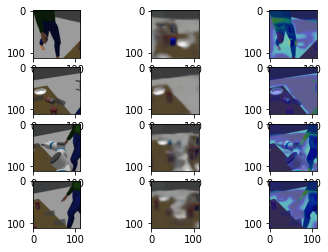

In [18]:
batch_size = 4
indices = np.random.randint(len(test_dataset), size=batch_size)
print("Images selected from: ", indices)

test_ims = []
for index in indices:
    test_ims.append(test_dataset[index])
test_ims = torch.stack(test_ims).to(device)
recon_ims = model(test_ims)

test_ims_np = test_ims.cpu().detach().numpy().swapaxes(1, 3).swapaxes(1, 2)
recon_ims_np = recon_ims.cpu().detach().numpy().swapaxes(1, 3).swapaxes(1, 2)

fig, axs = plt.subplots(batch_size, 3)
visualise(axs, test_ims_np, recon_ims_np)
plt.show()